# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import os
import pandas as pd
import numpy as np

from time import time
from datetime import date

RANDOM_STATE = 42

In [2]:
import matplotlib.pyplot as plt

In [3]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    OneHotEncoder
)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [4]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [5]:
import warnings
warnings.filterwarnings("ignore") 

## Подготовка данных

**Дано:** Датасет сервиса по продаже автомобилей.  


Признаки  
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

In [6]:
pth1 = '/datasets/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
else:
    print('Something is wrong')

In [7]:
def data_info(data):
    display(data.head(5),
            data.info(),
            data.describe(),
            data.isna().sum())
    print('Явных дубликатов: ', data.duplicated().sum())

In [8]:
data_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Явных дубликатов:  4


Cразу удалю данные, в которых год регистрации авто больше года выгрузки анкеты из базы:

In [9]:
data['DateCrawled']= pd.to_datetime(data['DateCrawled'])

In [10]:
data[data['DateCrawled'].dt.year < data['RegistrationYear']].shape[0]

14530

In [11]:
data = data[data['DateCrawled'].dt.year > data['RegistrationYear']]

Уберу не важные для предсказания колонки, связанные с самим сайтом и полные дубликаты:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- NumberOfPictures — количество фотографий автомобиля
- LastSeen — дата последней активности пользователя

In [12]:
data = data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'NumberOfPictures', 'LastSeen', 'RegistrationMonth'], axis = 1)
data = data.drop_duplicates()
data.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [13]:
data.duplicated().sum()

0

#### Обработка пропусков

Пропущенные значения все в категориальных признаках (+ Repaired)  
Посмотрю, есть ли ненормальные категории и заменю пропуск на "не указано" в категориальных признаках:

In [14]:
display(data['VehicleType'].unique(),
       data['Gearbox'].unique(),
       data['Model'].unique(),
       data['FuelType'].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', nan], dtype=object)

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'kadett', 'corsa', 'one', 'fortwo', 'clio', '1er',
       'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'polo', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'megane', 'lupo', 'r19', 'caddy',
       'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'berlingo',
       'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', 'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'fox', 'matiz', 'beetle', 'c1', 'rio',
       'touareg', '

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [15]:
data['VehicleType'] = data['VehicleType'].fillna('not specified')

In [16]:
data['Gearbox'] = data['Gearbox'].fillna('not specified')
data['Model'] = data['Model'].fillna('not specified')
data['FuelType'] = data['FuelType'].fillna('not specified')

Колонка Repaired, посомтрю как часто указывали, что был ремонт машины:

In [17]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [18]:
data['Repaired'].value_counts()

no     201079
yes     31073
Name: Repaired, dtype: int64

In [19]:
data['Repaired'] = data['Repaired'].fillna('unknown')
data['Repaired'].value_counts()

no         201079
unknown     54578
yes         31073
Name: Repaired, dtype: int64

In [20]:
display(data.isna().sum(),
        data.shape[0])

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

286730

#### Аномалии

In [21]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,286730.000000,286730.000000,286730.000000,286730.000000
mean,4623.394615,2001.898825,112.941373,126828.671573
std,4620.223791,14.557994,193.451095,38597.250815
min,0.000000,1000.000000,0.000000,5000.000000
25%,1150.000000,1999.000000,71.000000,125000.000000
50%,2915.500000,2003.000000,105.000000,150000.000000
75%,6750.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2015.000000,20000.000000,150000.000000


В Price(0), RegistrationYear(9999), Power(?), RegistrationMonth(0) есть странные значения, посмотрю поближе:

##### Price

In [22]:
data[data['Price'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,not specified,1990,not specified,0,corsa,150000,petrol,opel,unknown
115,0,small,1999,not specified,0,not specified,5000,petrol,volkswagen,unknown
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
154,0,not specified,2006,not specified,0,other,5000,not specified,fiat,unknown
...,...,...,...,...,...,...,...,...,...,...
354205,0,not specified,2000,manual,65,corsa,150000,not specified,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,unknown
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,unknown
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


**Price** это мой целевой признак, восстановить эту информацию не получится, машины, которые стоят 0 у.е. удалю из дата сета.

In [23]:
data = data[data['Price'] != 0]
data.shape[0]

279045

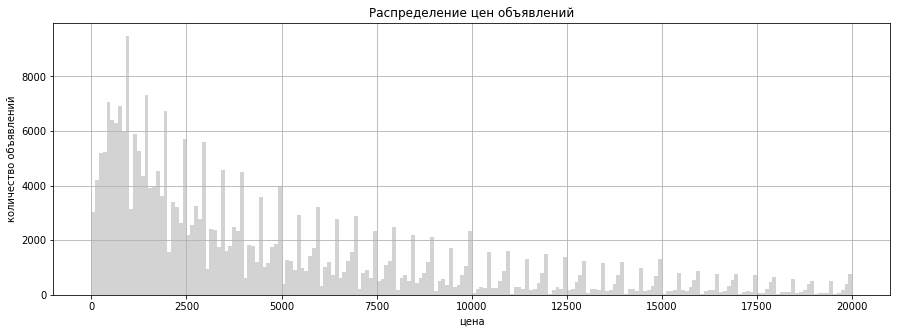

In [24]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
ax.set_title('Распределение цен объявлений')
ax.set_xlabel('цена')
ax.set_ylabel('количество объявлений')
data['Price'].hist(bins = 200, grid=True, ax = ax, color='lightgrey');

Есть повторяющийся паттерн выбросов, но они, возможно, связаны с круглыми ценами.  
Самое большое количество машин стоят до 2500 евро, более дорогих меньше, может быть связно с тем, что бизнес про подержанные машины.  
Всё равно очень много слишком дешёвых машин, предположим, машина не может стоит меньше 50 евро даже подержанная:

In [25]:
data[data['Price'] < 50]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
59,1,suv,1994,manual,286,not specified,150000,not specified,sonstige_autos,unknown
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
268,1,sedan,1990,manual,90,80,70000,petrol,audi,no
408,1,not specified,2000,not specified,75,golf,90000,petrol,volkswagen,unknown
901,1,not specified,1990,manual,0,other,150000,not specified,porsche,unknown
...,...,...,...,...,...,...,...,...,...,...
352889,1,bus,2005,manual,101,other,150000,gasoline,nissan,yes
352919,1,small,1998,manual,125,polo,150000,petrol,volkswagen,no
353252,1,coupe,1990,manual,45,polo,150000,petrol,volkswagen,no
353573,40,wagon,2011,not specified,0,5er,80000,not specified,bmw,unknown


Уберу эти данные тоже, их не очень много

In [26]:
data = data[data['Price'] > 500]
data.shape[0]

254366

##### RegistrationYear/Month

In [27]:
# Если считать, что раньше 1950 машин на ходу нет
data[(data['RegistrationYear'] > 2024) | (data['RegistrationYear'] < 1950)].shape[0]

100

Удалю строки с этими данными, их немного

In [28]:
data = data[(data['RegistrationYear'] < 2024) & (data['RegistrationYear'] > 1950)]
data.shape[0]

254253


##### Power

In [29]:
data[data['Power'] == 0].shape[0]

20372

In [30]:
data[data['Power'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
54,4700,wagon,2005,manual,0,signum,150000,not specified,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
69,1200,coupe,2001,not specified,0,astra,150000,not specified,opel,unknown
70,800,small,1993,manual,0,polo,150000,petrol,volkswagen,no
90,2400,sedan,2003,manual,0,a4,150000,gasoline,audi,unknown
...,...,...,...,...,...,...,...,...,...,...
354302,5990,bus,1984,auto,0,other,70000,petrol,chevrolet,unknown
354305,3500,not specified,1995,not specified,0,polo,150000,not specified,volkswagen,unknown
354332,7900,bus,2007,manual,0,b_klasse,125000,petrol,mercedes_benz,no
354346,2600,not specified,2005,auto,0,c_klasse,150000,not specified,mercedes_benz,unknown


К сожалению, не разбираюсь в автомобилях, но гугл говорит, что мощность автомобилей точно не может быть равна нулю и обычно не меньшая, чем 10 л.с.

In [31]:
data[data['Power'] < 15].shape[0]

20608

In [32]:
data = data[data['Power'] > 10]
data.shape[0]

233704

In [33]:
# Удалю так же мощности больше 1000 л.с.
data = data[data['Power'] < 1000]
data.shape[0]

233485

----

**Промежуточный вывод:**  
Данные были просмотрены и проанализированы, устранены пропуски и аномалии. В ходе этой работы пришлось удалить некоторые записи (осталось 233485/354369)

----

## Обучение моделей

 - Обучу простые модели (LinearRegression, RandomForest)
 - Обучу более сложные (LightGBM, Catboost)
 - Проведу сравнительные анализ по критериям заказчика (качество предсказания, скорость предсказания, время обучения).
 
Метрикой качества будет **RMSE** по условию.

In [34]:
features = data.drop(['Price'], axis = 1)
target = data['Price']

Проведу обработку признаков:

In [35]:
data['Kilometer'].unique()

array([125000, 150000,  90000,  30000,  70000, 100000,  60000,   5000,
        20000,  80000,  50000,  40000,  10000])

In [36]:
cat_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'RegistrationYear', 'Repaired', 'Kilometer']
num_features = ['Power']

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)

In [38]:
# Закодирую категориальные данные:
features_train_od = features_train.copy()
features_test_od = features_test.copy()

In [39]:
enc = OrdinalEncoder()

In [40]:
enc.fit(features_train[cat_features])

OrdinalEncoder()

In [41]:
features_train_od[cat_features] = enc.transform(features_train_od[cat_features])
features_train_od.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
321872,8.0,53.0,1.0,177,205.0,12.0,2.0,24.0,0.0
188377,2.0,32.0,1.0,136,167.0,12.0,7.0,20.0,1.0
47021,7.0,40.0,1.0,82,167.0,12.0,7.0,35.0,0.0
172714,1.0,43.0,1.0,75,116.0,12.0,7.0,38.0,0.0
101914,5.0,48.0,0.0,116,234.0,12.0,7.0,24.0,0.0


In [42]:
features_test_od[cat_features] = enc.transform(features_test_od[cat_features])
features_test_od.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
200099,5.0,46.0,1.0,125,28.0,12.0,7.0,1.0,0.0
55208,5.0,49.0,1.0,133,167.0,12.0,7.0,4.0,0.0
162541,6.0,50.0,1.0,82,33.0,11.0,7.0,20.0,0.0
301173,5.0,47.0,1.0,125,171.0,12.0,5.0,38.0,1.0
137560,6.0,51.0,1.0,80,214.0,11.0,7.0,9.0,2.0


In [43]:
# И числовые:
scaler = StandardScaler()

scaler.fit(features_train[num_features])

features_train_od[num_features] = scaler.transform(features_train_od[num_features])
display(features_train_od.head())

features_test_od[num_features] = scaler.transform(features_test_od[num_features])
display(features_test_od.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
321872,8.0,53.0,1.0,0.939918,205.0,12.0,2.0,24.0,0.0
188377,2.0,32.0,1.0,0.197486,167.0,12.0,7.0,20.0,1.0
47021,7.0,40.0,1.0,-0.780351,167.0,12.0,7.0,35.0,0.0
172714,1.0,43.0,1.0,-0.907108,116.0,12.0,7.0,38.0,0.0
101914,5.0,48.0,0.0,-0.164676,234.0,12.0,7.0,24.0,0.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
200099,5.0,46.0,1.0,-0.001703,28.0,12.0,7.0,1.0,0.0
55208,5.0,49.0,1.0,0.143162,167.0,12.0,7.0,4.0,0.0
162541,6.0,50.0,1.0,-0.780351,33.0,11.0,7.0,20.0,0.0
301173,5.0,47.0,1.0,-0.001703,171.0,12.0,5.0,38.0,1.0
137560,6.0,51.0,1.0,-0.816567,214.0,11.0,7.0,9.0,2.0


---

In [44]:
dir(OneHotEncoder)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_X',
 '_check_n_features',
 '_compute_drop_idx',
 '_fit',
 '_get_feature',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_transform',
 '_validate_data',
 '_validate_keywords',
 'fit',
 'fit_transform',
 'get_feature_names',
 'get_params',
 'inverse_transform',
 'set_params',
 'transform']

In [45]:
pip show scikit-learn

Name: scikit-learn
Version: 0.24.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: pyod, lightgbm
Note: you may need to restart the kernel to use updated packages.


In [46]:
features_train_lin = features_train.copy()
features_test_lin = features_test.copy()

In [47]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)

#OH_encoder.fit(features_train_lin[cat_features])
#features_train_lin[OH_encoder.get_feature_names()] = OH_encoder.transform(features_train_lin[cat_features])

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(features_train_lin[cat_features]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(features_test_lin[cat_features]))

OH_cols_train.index = features_train_lin.index
OH_cols_test.index = features_test_lin.index

numeric_X_train = features_train_lin.drop(cat_features, axis=1)
numeric_X_test = features_test_lin.drop(cat_features, axis=1)

features_train_lin = pd.concat([numeric_X_train, OH_cols_train], axis=1)
features_test_lin = pd.concat([numeric_X_test, OH_cols_test], axis=1)

In [48]:
features_train_lin[num_features] = scaler.transform(features_train_lin[num_features])
features_test_lin[num_features] = scaler.transform(features_test_lin[num_features])

In [49]:
features_train_lin.head()

,Power,0,1,2,3,4,5,6,7,8,...,381,382,383,384,385,386,387,388,389,390
321872,0.939918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
188377,0.197486,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
47021,-0.780351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
172714,-0.907108,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
101914,-0.164676,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
features_test_lin.head()

,Power,0,1,2,3,4,5,6,7,8,...,381,382,383,384,385,386,387,388,389,390
200099,-0.001703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
55208,0.143162,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
162541,-0.780351,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
301173,-0.001703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
137560,-0.816567,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


---

##### Линейная регрессия:

In [55]:
final_result=[]

In [56]:
linear_regression=[]

In [57]:
%%time

# Время обучения с train
start = time()

model_linear = LinearRegression()
model_linear.fit(features_train_lin, target_train_lin)

end = time()

linear_regression.append(end-start)

CPU times: user 15.1 s, sys: 6.33 s, total: 21.5 s
Wall time: 21.4 s


In [58]:
%%time

#Время предсказания с valid
start = time()

linear_predictions = model_linear.predict(features_train_lin)

end = time()

linear_regression.append(end-start)

RMSE:  2051.141219824979
CPU times: user 86.5 ms, sys: 111 ms, total: 197 ms
Wall time: 198 ms


In [59]:
RMSE = (cross_val_score(model_linear,
                        
                       features_train_lin,
                       target_train_lin,
                        
                       cv=3,
                       scoring='neg_mean_squared_error').mean() * -1) ** 0.5

linear_regression.append(RMSE)
RMSE

2078.4676401139463

---


##### Cлучайный лес

In [60]:
random_forest=[]

In [61]:
def rmse(actual, predict):
    score = mean_squared_error(actual, predict) ** 0.5
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [62]:
%%time

parameters = {'n_estimators': range(5,11,5),
              'max_depth': range(1,8,3)}

model_forest = RandomForestRegressor()
grid = GridSearchCV(model_forest, parameters, cv=3, scoring=rmse_score)
grid.fit(features_train_od, target_train)

# Это RMSE c кроссвалидации
display(grid.best_params_,
        -1*grid.best_score_)

{'max_depth': 7, 'n_estimators': 10}

2124.972805634027

CPU times: user 9.89 s, sys: 110 ms, total: 10 s
Wall time: 10.6 s


In [63]:
%%time

model_forest = RandomForestRegressor(max_depth=7, n_estimators=10, random_state=RANDOM_STATE)

# Обчение на выборке
start = time()

model_forest.fit(features_train_od, target_train)

end = time()

random_forest.append(end-start)

CPU times: user 1.52 s, sys: 14.4 ms, total: 1.54 s
Wall time: 1.55 s


In [64]:
%%time

#Предсказание на выборке
start = time()

forest_predictions = model_forest.predict(features_train_od)

end = time()

random_forest.append(end-start)

CPU times: user 93.9 ms, sys: 1.18 ms, total: 95 ms
Wall time: 101 ms


In [65]:
random_forest.append(-1*grid.best_score_)

##### LightGBM

In [66]:
lgbm_list = []

In [67]:
%%time

model_light = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=RANDOM_STATE)
parameters = {'learning_rate': np.logspace(-3, 0, 5),
              'n_estimators': range(20, 61, 20)}

grid = GridSearchCV(model_light, parameters, cv=3, scoring=rmse_score)
grid.fit(features_train_od, target_train);

# RMSE на кроссвалидации
display(grid.best_params_,
        -1*grid.best_score_)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.206635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

{'learning_rate': 0.1778279410038923, 'n_estimators': 60}

1697.1289713734798

CPU times: user 1min 36s, sys: 0 ns, total: 1min 36s
Wall time: 1min 37s


In [68]:
%%time


model_light = LGBMRegressor(boosting_type='gbdt', learning_rate = 0.17, 
                            n_estimators = 60, verbose=0, seed=RANDOM_STATE)

# Время обучения 
start = time()

model_light.fit(features_train_od, target_train)

end = time()

lgbm_list.append(end-start)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
CPU times: user 2.95 s, sys: 0 ns, total: 2.95 s
Wall time: 2.99 s


In [69]:
%%time

# Время предсказания
start = time()

light_predictions = model_light.predict(features_train_od)

end = time()

lgbm_list.append(end-start)

CPU times: user 788 ms, sys: 0 ns, total: 788 ms
Wall time: 800 ms


In [70]:
lgbm_list.append(-1*grid.best_score_)

In [71]:
lgbm_list

[2.993591547012329, 0.7994289398193359, 1697.1289713734798]

##### Catboost

In [72]:
cat_list=[]

In [73]:
%%time

model_cat = CatBoostRegressor(loss_function='RMSE', silent=True, random_seed=RANDOM_STATE)
parameters = {'learning_rate': np.logspace(-3, 0, 5),
              'iterations': range(20, 60, 20)}

grid = GridSearchCV(model_cat, parameters, cv=3, scoring=rmse_score)
grid.fit(features_train_od, target_train);

# RMSE
display(grid.best_params_,
        -1*grid.best_score_)

{'iterations': 40, 'learning_rate': 1.0}

1755.2588871163944

CPU times: user 16.4 s, sys: 0 ns, total: 16.4 s
Wall time: 40 s


In [74]:
%%time

model_cat = grid.best_estimator_

# Время обучения
start = time()
model_cat.fit(features_train_od, target_train)

end = time()

cat_list.append(end-start)

CPU times: user 951 ms, sys: 0 ns, total: 951 ms
Wall time: 1.56 s


In [75]:
%%time

# Время предсказания
start = time()

cat_predictions = model_cat.predict(features_train_od)

end = time()

cat_list.append(end-start)

CPU times: user 22.7 ms, sys: 0 ns, total: 22.7 ms
Wall time: 21.3 ms


In [76]:
cat_list.append(-1*grid.best_score_)
cat_list

[1.556868553161621, 0.021168231964111328, 1755.2588871163944]

## Анализ моделей




По трем важным для заказчика параметрам оценки моделей наиболее предпочтительной выглядит **Catboost** (model_cat). LGBM имеет лучшую RMSE, но время ее обучения значительно дольше. Простые модели имеют худшее качество.

In [77]:
# Соберу что получилось в таблицу
final_result.append(linear_regression)
final_result.append(random_forest)
final_result.append(lgbm_list)
final_result.append(cat_list)

In [78]:
final_result = pd.DataFrame(final_result, index=['linear', 'forest', 'lgbm', 'catboost'],
                            columns=['train', 'predict', 'rmse'])

In [79]:
final_result 

,train,predict,rmse
linear,21.412601,0.198147,2078.467640
forest,1.548963,0.101202,2124.972806
lgbm,2.993592,0.799429,1697.128971
catboost,1.556869,0.021168,1755.258887


Сравню лучшую свою модель с константной на тестовой выборке:

In [80]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train_od, target_train)
predictions_d = dummy_regr.predict(features_test_od)

print('RMSE dummy: ', mean_squared_error(target_test, predictions_d) ** 0.5)

RMSE dummy:  4656.418791447832


In [81]:
cat_predictions = model_cat.predict(features_test_od)

print('RMSE model: ', mean_squared_error(target_test, cat_predictions) ** 0.5)

RMSE model:  1732.2297152341198


Метрика качества полученной модели превосходит результат dummy значительно.

## Вывод

**Дано:** данные по автомобилям  
**Задача:** построить модель для определения стоимости автомобиля, критерии оценки: RMSE, скорость обучения и предсказания

----

Предобработка данных:

- были удалены/заполнены пропуски в данных и дубликаты
- устранены аномальные значения
- данные были отскалированы и закодированы для дальнейшей работы

Обучение моделей:
- были обучены 4 модели: LinearRegression, RandomForest, LGBM, Catboost
- для каждой модели найдены интересующие заказчика параметры в таблице ниже:

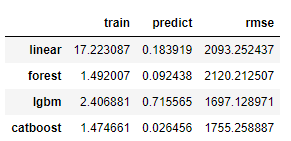

----

Наиболее подходящей заказчику моделью является model_cat, если более важным критерием является скорость.   
Если важнее RMSE, то стоит выбрать model_light.